# Report

---

In this notebook, I provided a description of my implementation.

### 1. Start the Environment

We begin by importing some necessary packages.

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!

In [2]:
env = UnityEnvironment(file_name="./Banana.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

The code below returns some information about the environment

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
print(brain_name)
print(brain)

BananaBrain
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
banana_action_size = brain.vector_action_space_size
print('Number of actions:', banana_action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
banana_state_size = len(state)
print('States have length:', banana_state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Define the NN model that will be used for Q value function estimation

Below model is inspured from the Q-learning lab and pytorch extended modules... 

It defines a NN with variable number of hiddnen and dense layers. At input it gets a tensor having a number of elements equal with the number of states and the output of the NN is producing the Q value estimates for all 4 actions given a certain state at the input.

The NN is also containing an optional droput layer in between each hidden layer, defaulted to 0.2.

The model is coded in the [banana_brain_model.py](./banana_brain_model.py). You can inspect this file to check its implementation (it is inspired from QLearning module lab)

### 4. Define the DDQN Agent

The Smart Agent that is going to be learned to control the BananaBrain is coded in the [banana_brain_agent.py](./banana_brain_agent.py). You can inspect this file to check its implementation (it was inspired from the QLearning module lab). 

The agent is constructed with Double DQN learning algorithm. The agent can be initialized for learning or for play only based on a saved checkpoint.

Below are initialized the hiper parameters of the model that can be used to tune the training process of the agent.

In [5]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

banana_model_hidden_layers = [64, 32]  # number of hidden layers is the length of thre list and the units in each layer

from banana_brain_agent import BananaBrainAgent

### 5. Instantiate the learning Agent defined above

Instantiate the BananaBrainAgent and leave it interract with the environment for an episode, event if the agent is untrained.

In [6]:


banana_agent = BananaBrainAgent(state_size=banana_state_size, 
                                action_size=banana_action_size, 
                                seed=0, 
                                hidden_layers = banana_model_hidden_layers, 
                                drop_p = 0.2
                                )

# reset the environment to check how the untrained agent behaves
env_info = env.reset(train_mode=False)[brain_name] 
# watch an untrained agent
state = env_info.vector_observations[0]            # get the current state
score = 0   # initialize the score

while True:
    action = banana_agent.act(state)               # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


### 6. Train the Agent with DQN

Run the code cell below to train the agent from scratch. 

Episode 480	Average Score: 13.57
Environment solved in 380 episodes!	Average Score: 13.57


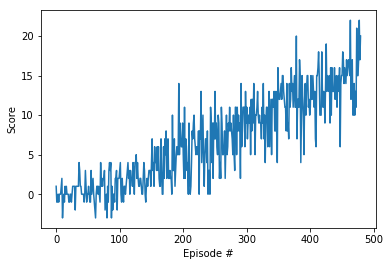

In [7]:
from collections import namedtuple, deque
import matplotlib.pyplot as plt
%matplotlib inline

def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        # reset the environment to check how the untrained agent behaves
        env_info = env.reset(train_mode=True)[brain_name] 
        state = env_info.vector_observations[0]            # get the current state
        score = 0  #initialize the score for the episode
        
        for t in range(max_t):
            action = banana_agent.act(state, eps)         # get the action from the agent
            
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished

            # send the step data back to the agent to be used for learning
            banana_agent.step(state, action, reward, next_state, done) 
            
            state = next_state
            score += reward
            if done:
                break 
                
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="\r")
        if np.mean(scores_window)>=13.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            
            # save model when environment solved (more than 13 points in avrage over last 100 consecutive episodes)
            banana_agent.save_agent_model("banana-model-checkpoint.pth")
            break
    return scores

scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 7. Play with the trained agent in the environment
In the cell below the trained agent is used to play in the environment...

In [18]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
# initialize the score
no_yellow_bananas = 0   
no_blue_bananas = 0
total_score = 0
while True:
    action = banana_agent.act(state)               # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    if reward == 1:
        no_yellow_bananas += 1
    if reward == -1:
        no_blue_bananas += 1  
    total_score += reward
    print("Current score: {}".format(total_score), end = '\r')
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("No yellow bananas picked: {}".format(no_yellow_bananas))
print("No blue bananas picked  : {}".format(no_blue_bananas))
print("Total score: {}".format(total_score), end = '\r')

No yellow bananas picked: 18
No blue bananas picked  : 0


When finished, you can close the environment.

In [19]:
env.close()

### Ideas for future improvements

There are several improvements that can be made:
   a) tune the hyper-parameters to train even faster
   b) change the agent to the screen pixels type of input state